In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns:    
    display(Markdown(string))

In [2]:
image_dir = Path('../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images')

# Get filepaths and labels:
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [3]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels:
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index:
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result:
image_df.head(3)

,Filepath,Label
0,../input/diabetic-retinopathy-224x224-gaussian...,Severe
1,../input/diabetic-retinopathy-224x224-gaussian...,No_DR
2,../input/diabetic-retinopathy-224x224-gaussian...,Moderate


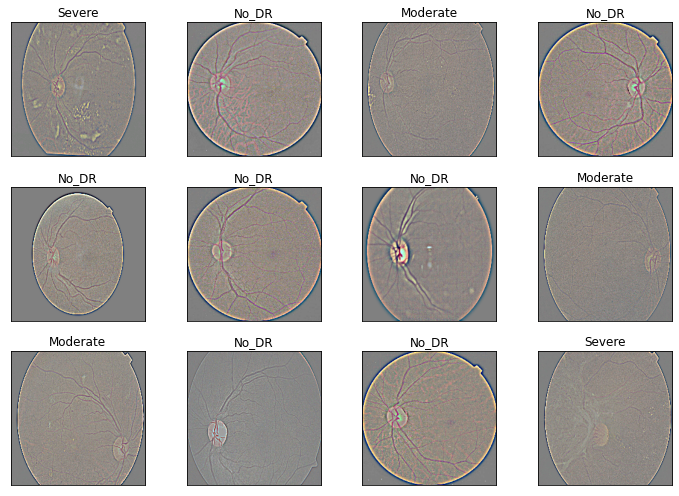

In [4]:
# Display some pictures of the dataset with their labels:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

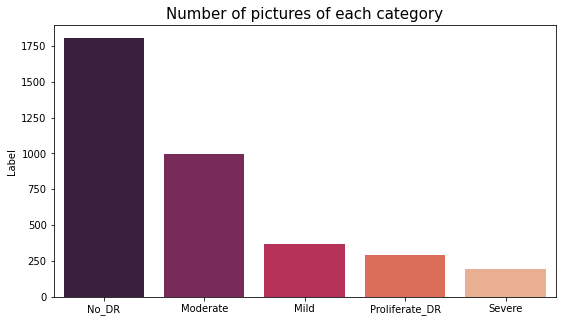

In [5]:
# Display the number of pictures of each category:
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()


In [6]:
def create_gen():
    # Load the Images with a generator and Data Augmentation:
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation!
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation!
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [7]:
def get_model(model):
# Load the pretained model:
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [8]:
# Map the labels to have only "No_DR" and "DR":
image_df_red = image_df.copy()
image_df_red['Label'] = image_df_red['Label'].apply(lambda x: x if x == 'No_DR' else 'DR')
image_df_red.head(5)

,Filepath,Label
0,../input/diabetic-retinopathy-224x224-gaussian...,DR
1,../input/diabetic-retinopathy-224x224-gaussian...,No_DR
2,../input/diabetic-retinopathy-224x224-gaussian...,DR
3,../input/diabetic-retinopathy-224x224-gaussian...,No_DR
4,../input/diabetic-retinopathy-224x224-gaussian...,No_DR


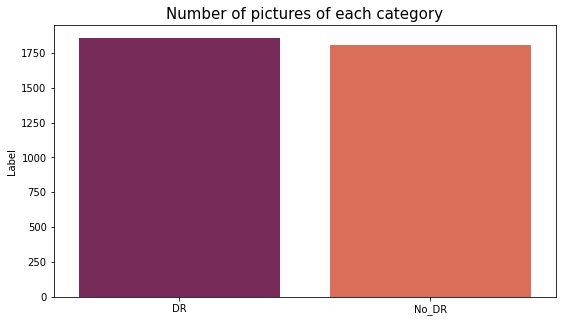

In [9]:
# Display the number of pictures of each category:
vc = image_df_red['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [10]:
# Separate in train and test data:

train_df, test_df = train_test_split(image_df_red, train_size=0.9, shuffle=True, random_state=1)

In [11]:
# Create the generators:

train_generator,test_generator,train_images,val_images,test_images=create_gen()

# Load the pretained model:

pretrained_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False


inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy','AUC']
)


Found 2966 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.
Found 367 validated image filenames belonging to 2 classes.
94773248/94765736 [==============================] - 1s 0us/stepTA: 


In [12]:
history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=50)

Epoch 1/50
93/93 [==============================] - 39s 313ms/step - loss: 0.4159 - accuracy: 0.8197 - auc: 0.8816 - val_loss: 0.3884 - val_accuracy: 0.8663 - val_auc: 0.9174
Epoch 2/50
93/93 [==============================] - 11s 115ms/step - loss: 0.3263 - accuracy: 0.8808 - auc: 0.9322 - val_loss: 0.3186 - val_accuracy: 0.8693 - val_auc: 0.9347
Epoch 3/50
93/93 [==============================] - 11s 117ms/step - loss: 0.2728 - accuracy: 0.8922 - auc: 0.9537 - val_loss: 0.3127 - val_accuracy: 0.8784 - val_auc: 0.9361
Epoch 4/50
93/93 [==============================] - 11s 120ms/step - loss: 0.2631 - accuracy: 0.8959 - auc: 0.9558 - val_loss: 0.2805 - val_accuracy: 0.8784 - val_auc: 0.9514
Epoch 5/50
93/93 [==============================] - 11s 113ms/step - loss: 0.2601 - accuracy: 0.9031 - auc: 0.9566 - val_loss: 0.2720 - val_accuracy: 0.8784 - val_auc: 0.9546
Epoch 6/50
93/93 [==============================] - 10s 112ms/step - loss: 0.2553 - accuracy: 0.9043 - auc: 0.9582 - val_loss

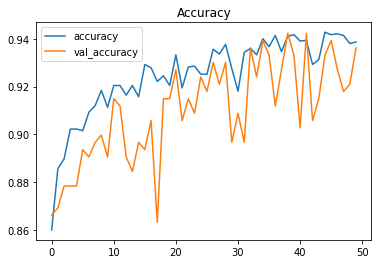

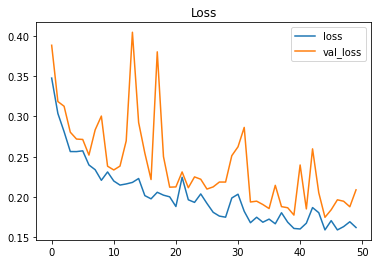

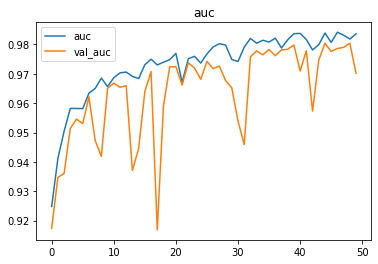

 ## Test Loss: 0.16512

## Accuracy on the test set: 92.92%

In [14]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

pd.DataFrame(history.history)[['auc','val_auc']].plot()
plt.title("auc")
plt.show()

results = model.evaluate(test_images, verbose=0)

printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))
print('\n')

In [15]:
# Predict the label of the test_images:

pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label:
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

from sklearn.metrics import classification_report
y_test = list(test_df.Label)
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test,pred),5))
print('Precision:', np.round(metrics.precision_score(y_test,pred, average='weighted'),5))
print('Recall:', np.round(metrics.recall_score(y_test,pred, average='weighted'),5))
print('F1 Score:', np.round(metrics.f1_score(y_test,pred, average='weighted'),5))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test,pred),5))
print(classification_report(y_test, pred))

Accuracy: 0.92916
Precision: 0.92946
Recall: 0.92916
F1 Score: 0.9292
Cohen Kappa Score: 0.85795
              precision    recall  f1-score   support

          DR       0.94      0.92      0.93       195
       No_DR       0.91      0.94      0.93       172

    accuracy                           0.93       367
   macro avg       0.93      0.93      0.93       367
weighted avg       0.93      0.93      0.93       367



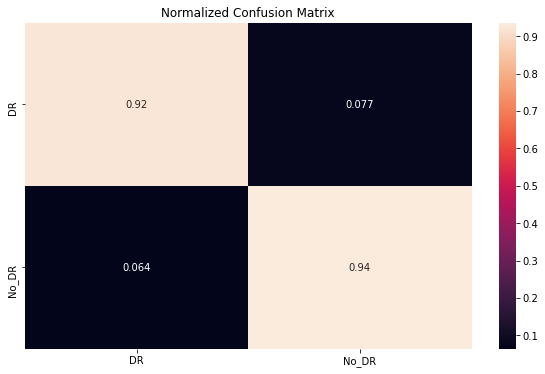

In [16]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()